In [151]:
using Pkg
Pkg.instantiate()

In [152]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization, Chain, DataFramesMeta
using Statistics, FFTW
import ColorSchemes as co 

In [153]:
image_data = "data//metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  32_col_3_grow_type_22023_12_19.csv
2  32_col_3_grow_type_22023_12_19.jls
3  8_col_3_grow_type_22023_12_19.csv
4  8_col_3_grow_type_22023_12_19.jls
5  artifical_2023_09_14.csv
6  artifical_2023_09_14.jls
7  artifical_2023_long_evo.csv
8  artifical_2023_long_evo.jls
9  data_sets_10_2023-09-26.csv
10  data_sets_10_2023-09-26.jls


In [175]:
data_a = deserialize(joinpath(image_data,readdir(image_data)[6]))
first(data_a,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589
2,circular 2023_09_14,Colony 1 artifical,6,"[0, 16, 8, 15, 9, 13, 10, 11, 11, 11 … 11, 11, 11, 11, 10, 13, 9, 15, 8, 24]","[0, 0, 0, 0, 0, 0, 2, 1, 2, 0 … 1, 0, 2, 1, 2, 0, 0, 0, 0, 0]","[4777, 6026, 5632, 5269, 5435, 5700, 5729, 5388, 5479, 5709 … 5670, 5398, 5345, 5526, 5728, 5488, 5298, 5737, 5884, 5304]","[0, 8078, 6309, 3269, 5931, 7992, 6130, 4269, 5048, 6783 … 6837, 5005, 4440, 6278, 7680, 5914, 3166, 6370, 7900, 6909]",20589


In [176]:
unique(data_a.data_set)

5-element Vector{String}:
 "circular 2023_09_14"
 "random 2023_09_14"
 "random_fractal 2023_09_14"
 "random_finger_weak 2023_09_14"
 "random_finger_strong 2023_09_14"

In [177]:
data_r = deserialize(joinpath(image_data,readdir(image_data)[end]))
first(data_r,2)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992


In [178]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data_r )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [179]:
path = "analysis\\comparison"
mkpath(path)

ana_para = analysis_parameters(plot_theme =
    Theme(  fontsize = 30,
    size = (1000,800),
    Scatter = (markersize = 18,
    label = "Real Colonies",),                
    Lines  = (linewidth =4,),
    Errorbars = (whiskerwidth = 20, 
    color = :black)
    ))
update_theme!(ana_para.plot_theme)

In [180]:
pair_max_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

first(pair_max_single, 3)

pair_max_r = @chain data_full begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64
1,0,0.0590085,0.0193867
2,3,0.534521,0.406161
3,4,0.603532,0.221662
4,19,0.458936,0.274609
5,20,0.318402,0.1617
6,24,0.684652,0.22927
7,43,1.12358,0.163496
8,44,1.01706,0.190581
9,48,1.25448,0.281709


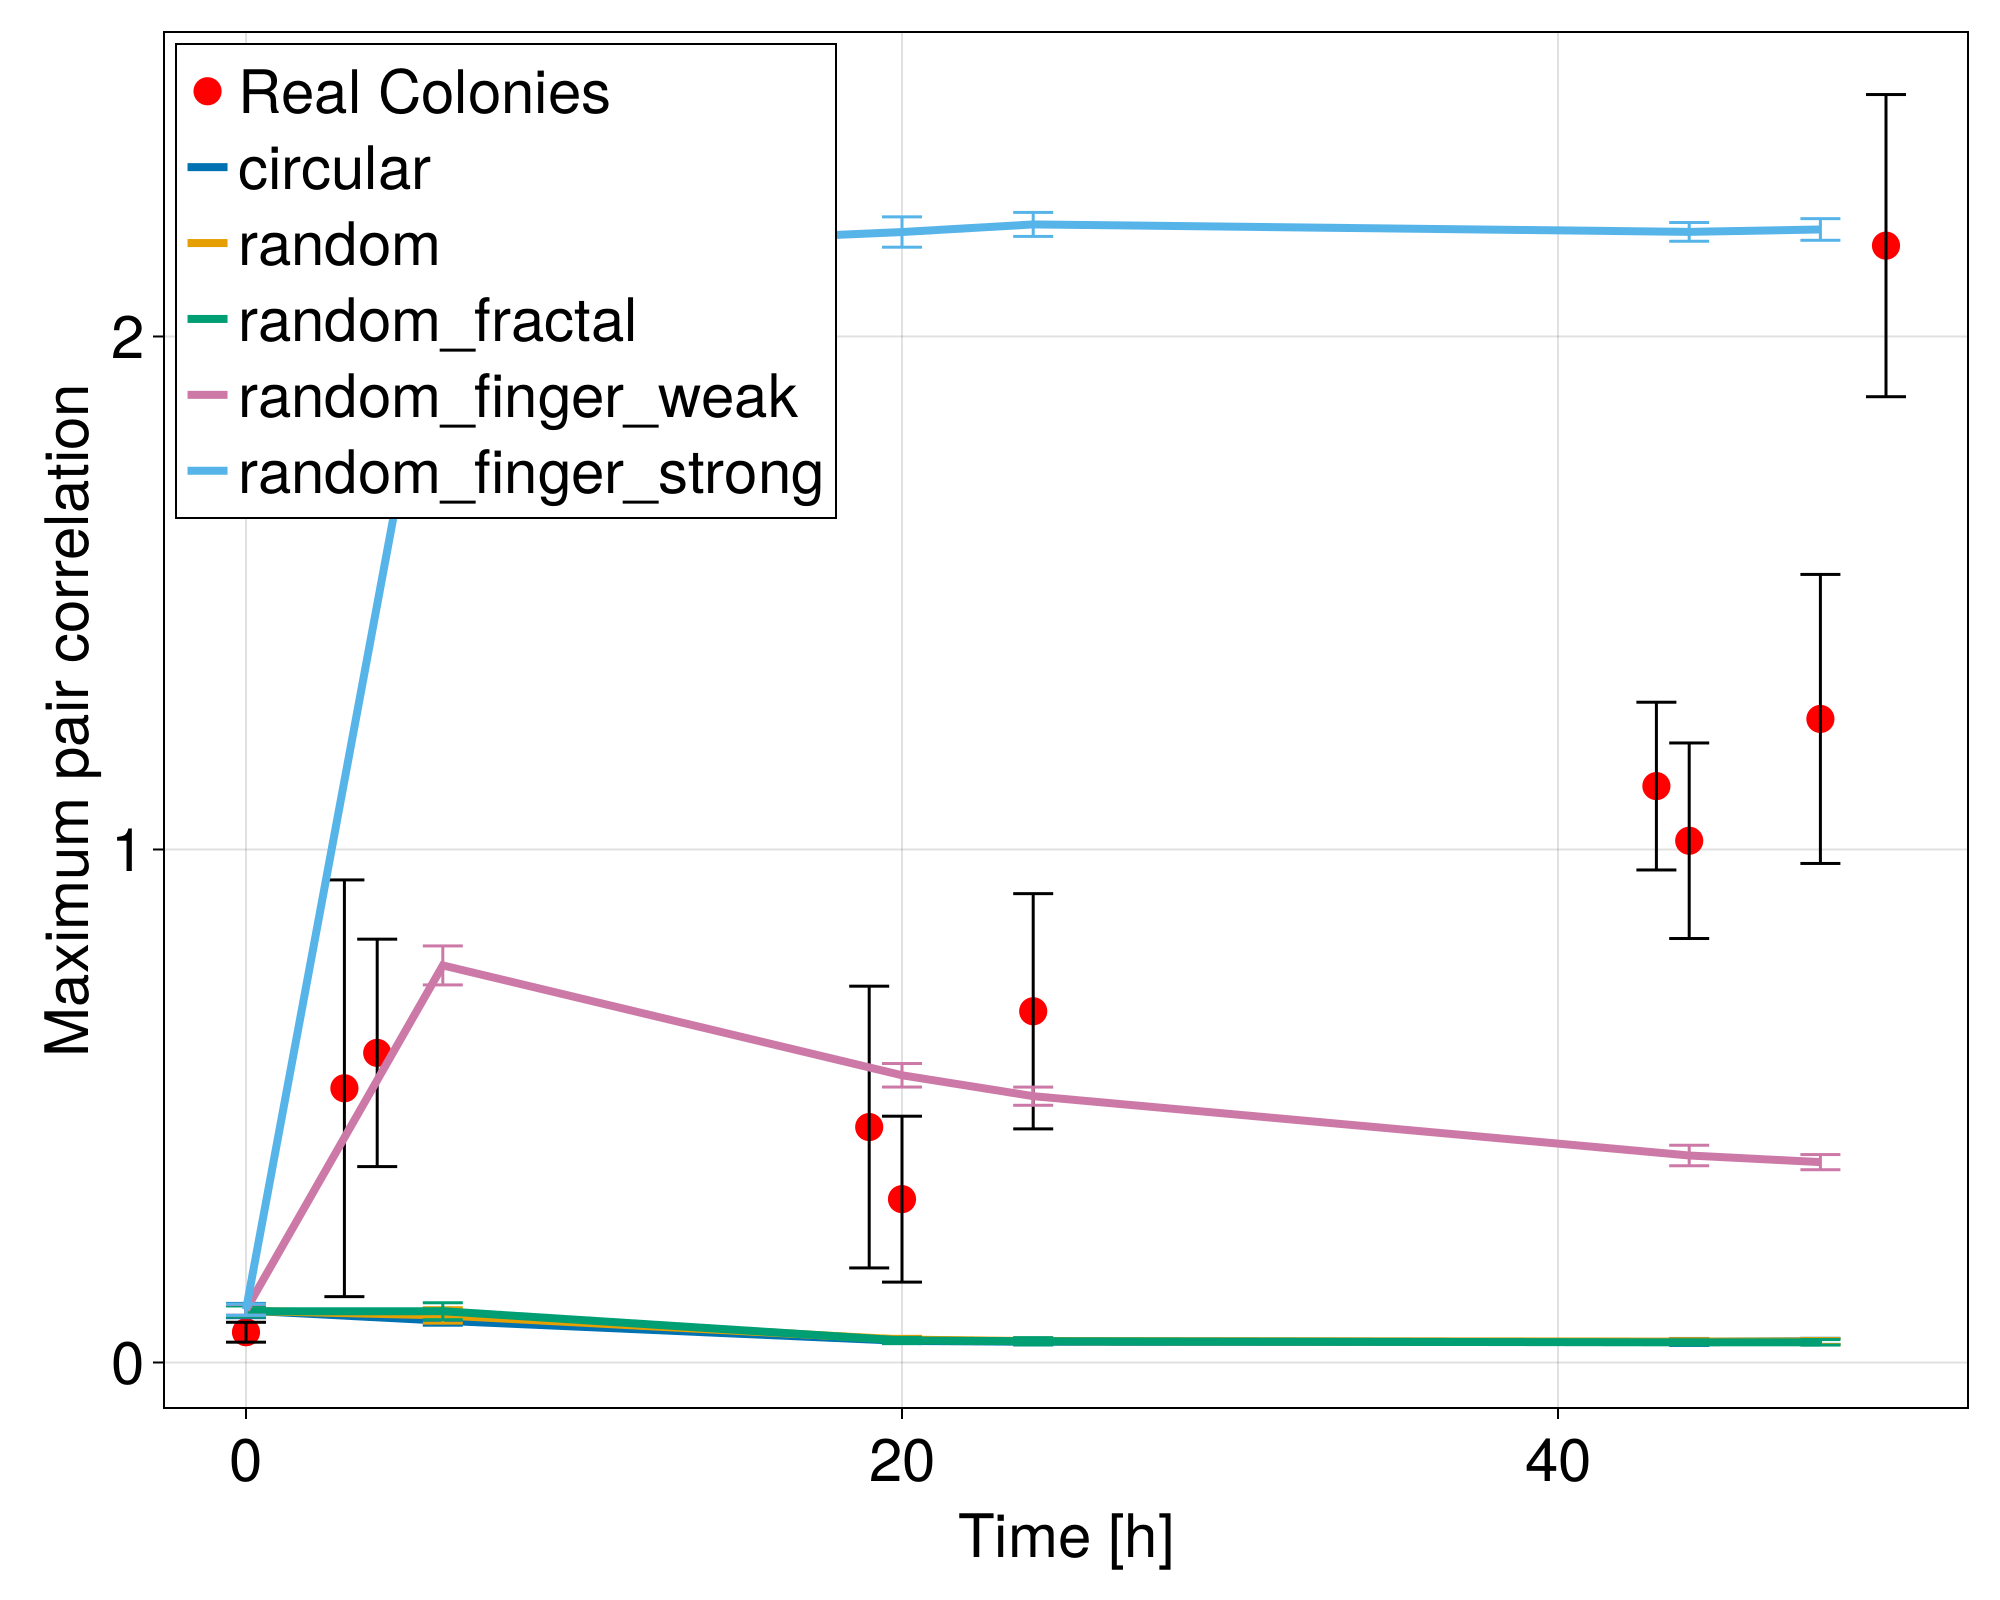

In [181]:
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1])
scatter!(ax,pair_max_r.time,pair_max_r.pair_og, markersize = 20, color = "red")
errorbars!(ax,pair_max_r.time,pair_max_r.pair_og, pair_max_r.pair_og_stdd,whiskerwidth = 20, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Maximum pair correlation"
j = 1
for (k, i) in pairs(groupby(pair_max_single,:data_set))
    lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_MaxP1.pdf"),fig1)
fig1

## root mean square fluctations

In [182]:
cv_angular_max = @chain data_a begin
    groupby(:time)
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))), :cv_angu_std = std(std.(:metric_cov)./(mean.(:metric_cov))))
end
first(cv_angular_max,3)

cv_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))), :cv_angu_std = std(std.(:metric_cov)./(mean.(:metric_cov))))
end
first(cv_angular_max_single,3)

Row,time,data_set,cv_angu,cv_angu_std
,Int64,String,Float64,Float64
1,0,circular 2023_09_14,0.116954,1.40998e-17
2,6,circular 2023_09_14,0.724817,1.12799e-16
3,20,circular 2023_09_14,0.86883,2.25598e-16


In [183]:
cv_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

Row,time,cv_OG,cv_OG_std
,Int64,Float64,Float64
1,0,NaN,NaN
2,3,0.695513,0.237475
3,4,0.720371,0.135934
4,19,0.639922,0.231289
5,20,0.548096,0.151844
6,24,0.818629,0.145498
7,43,1.06527,0.0807563
8,44,1.01741,0.09607
9,48,1.12087,0.124787


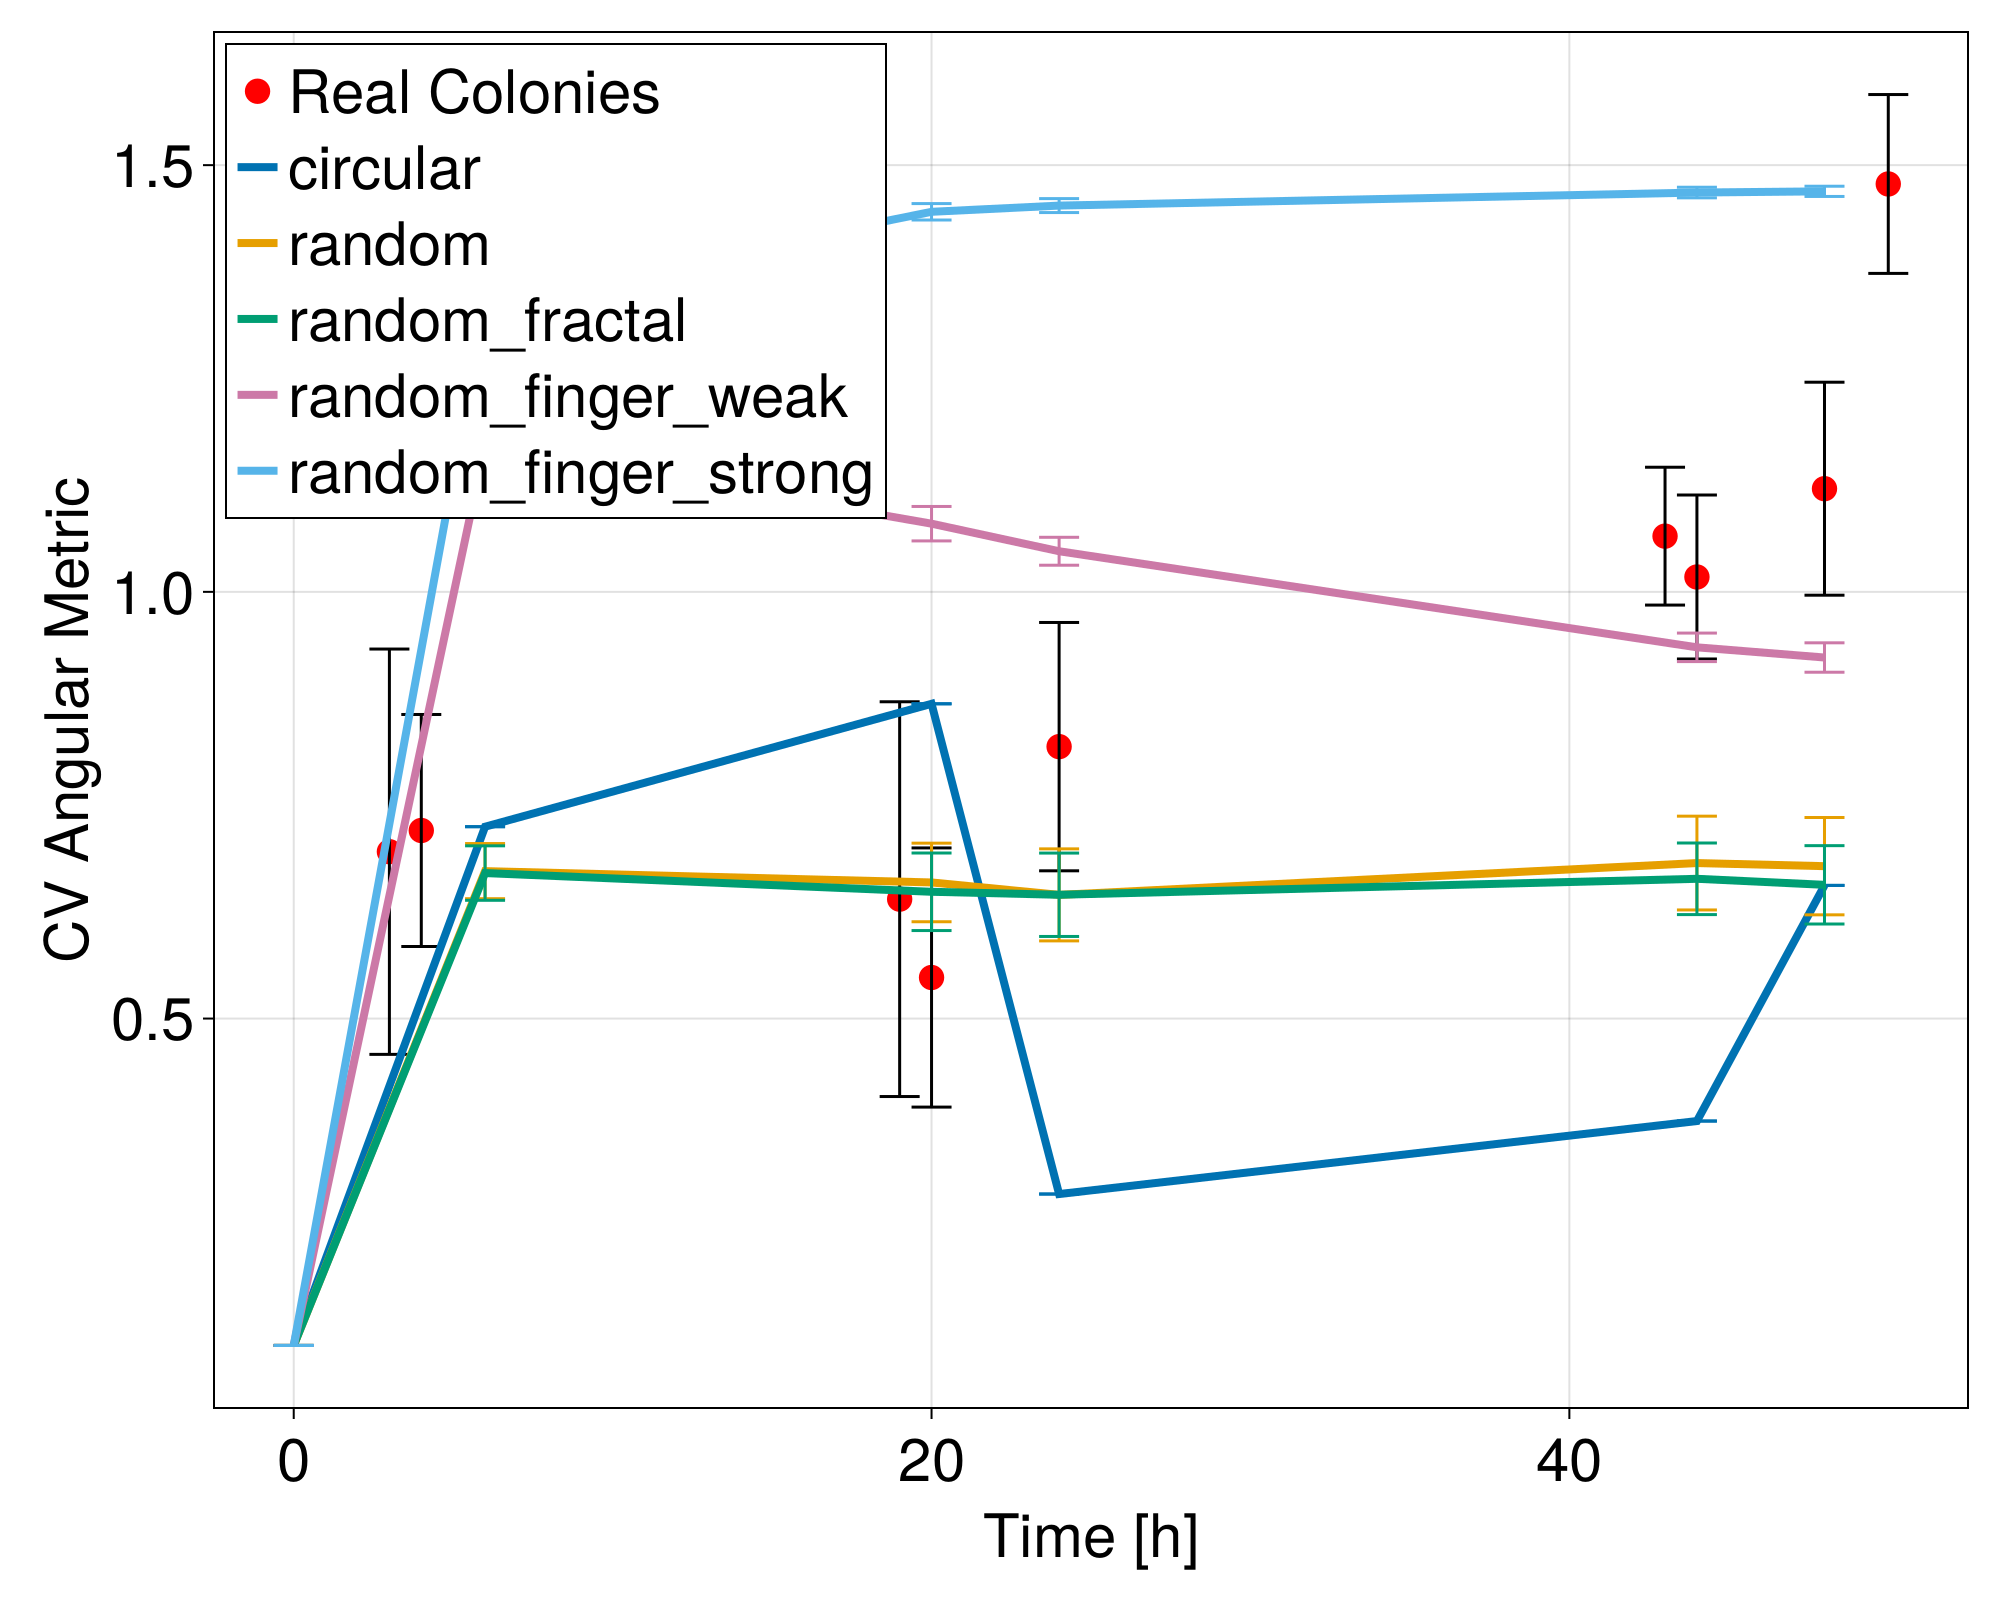

In [184]:
fig3 = Figure()
ax = CairoMakie.Axis(fig3[1,1])
scatter!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, color = :red)
errorbars!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, cv_angular_max_r.cv_OG_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    lines!(ax, i.time, i.cv_angu, label  = mk_label(k.data_set))
    errorbars!(ax, i.time, i.cv_angu,i.cv_angu_std )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_CV.pdf"),fig3)
fig3

## Root mean square fluctations/roughness

In [185]:
roughness_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = mean(std.(:metric_cov)))
end
first(roughness_angular_max_single)

Row,time,data_set,roughness_angu
,Int64,String,Float64
1,0,circular 2023_09_14,6.68882


In [186]:
roughness_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG)),:roughness_OG_std = std(std.(:metric_OG)))
end

Row,time,roughness_OG,roughness_OG_std
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,4.52467,4.76343
3,4,3.01044,1.35788
4,19,34.7599,21.9436
5,20,23.0157,7.95766
6,24,48.8446,23.8872
7,43,181.523,33.9552
8,44,151.611,29.2072
9,48,185.017,52.0155


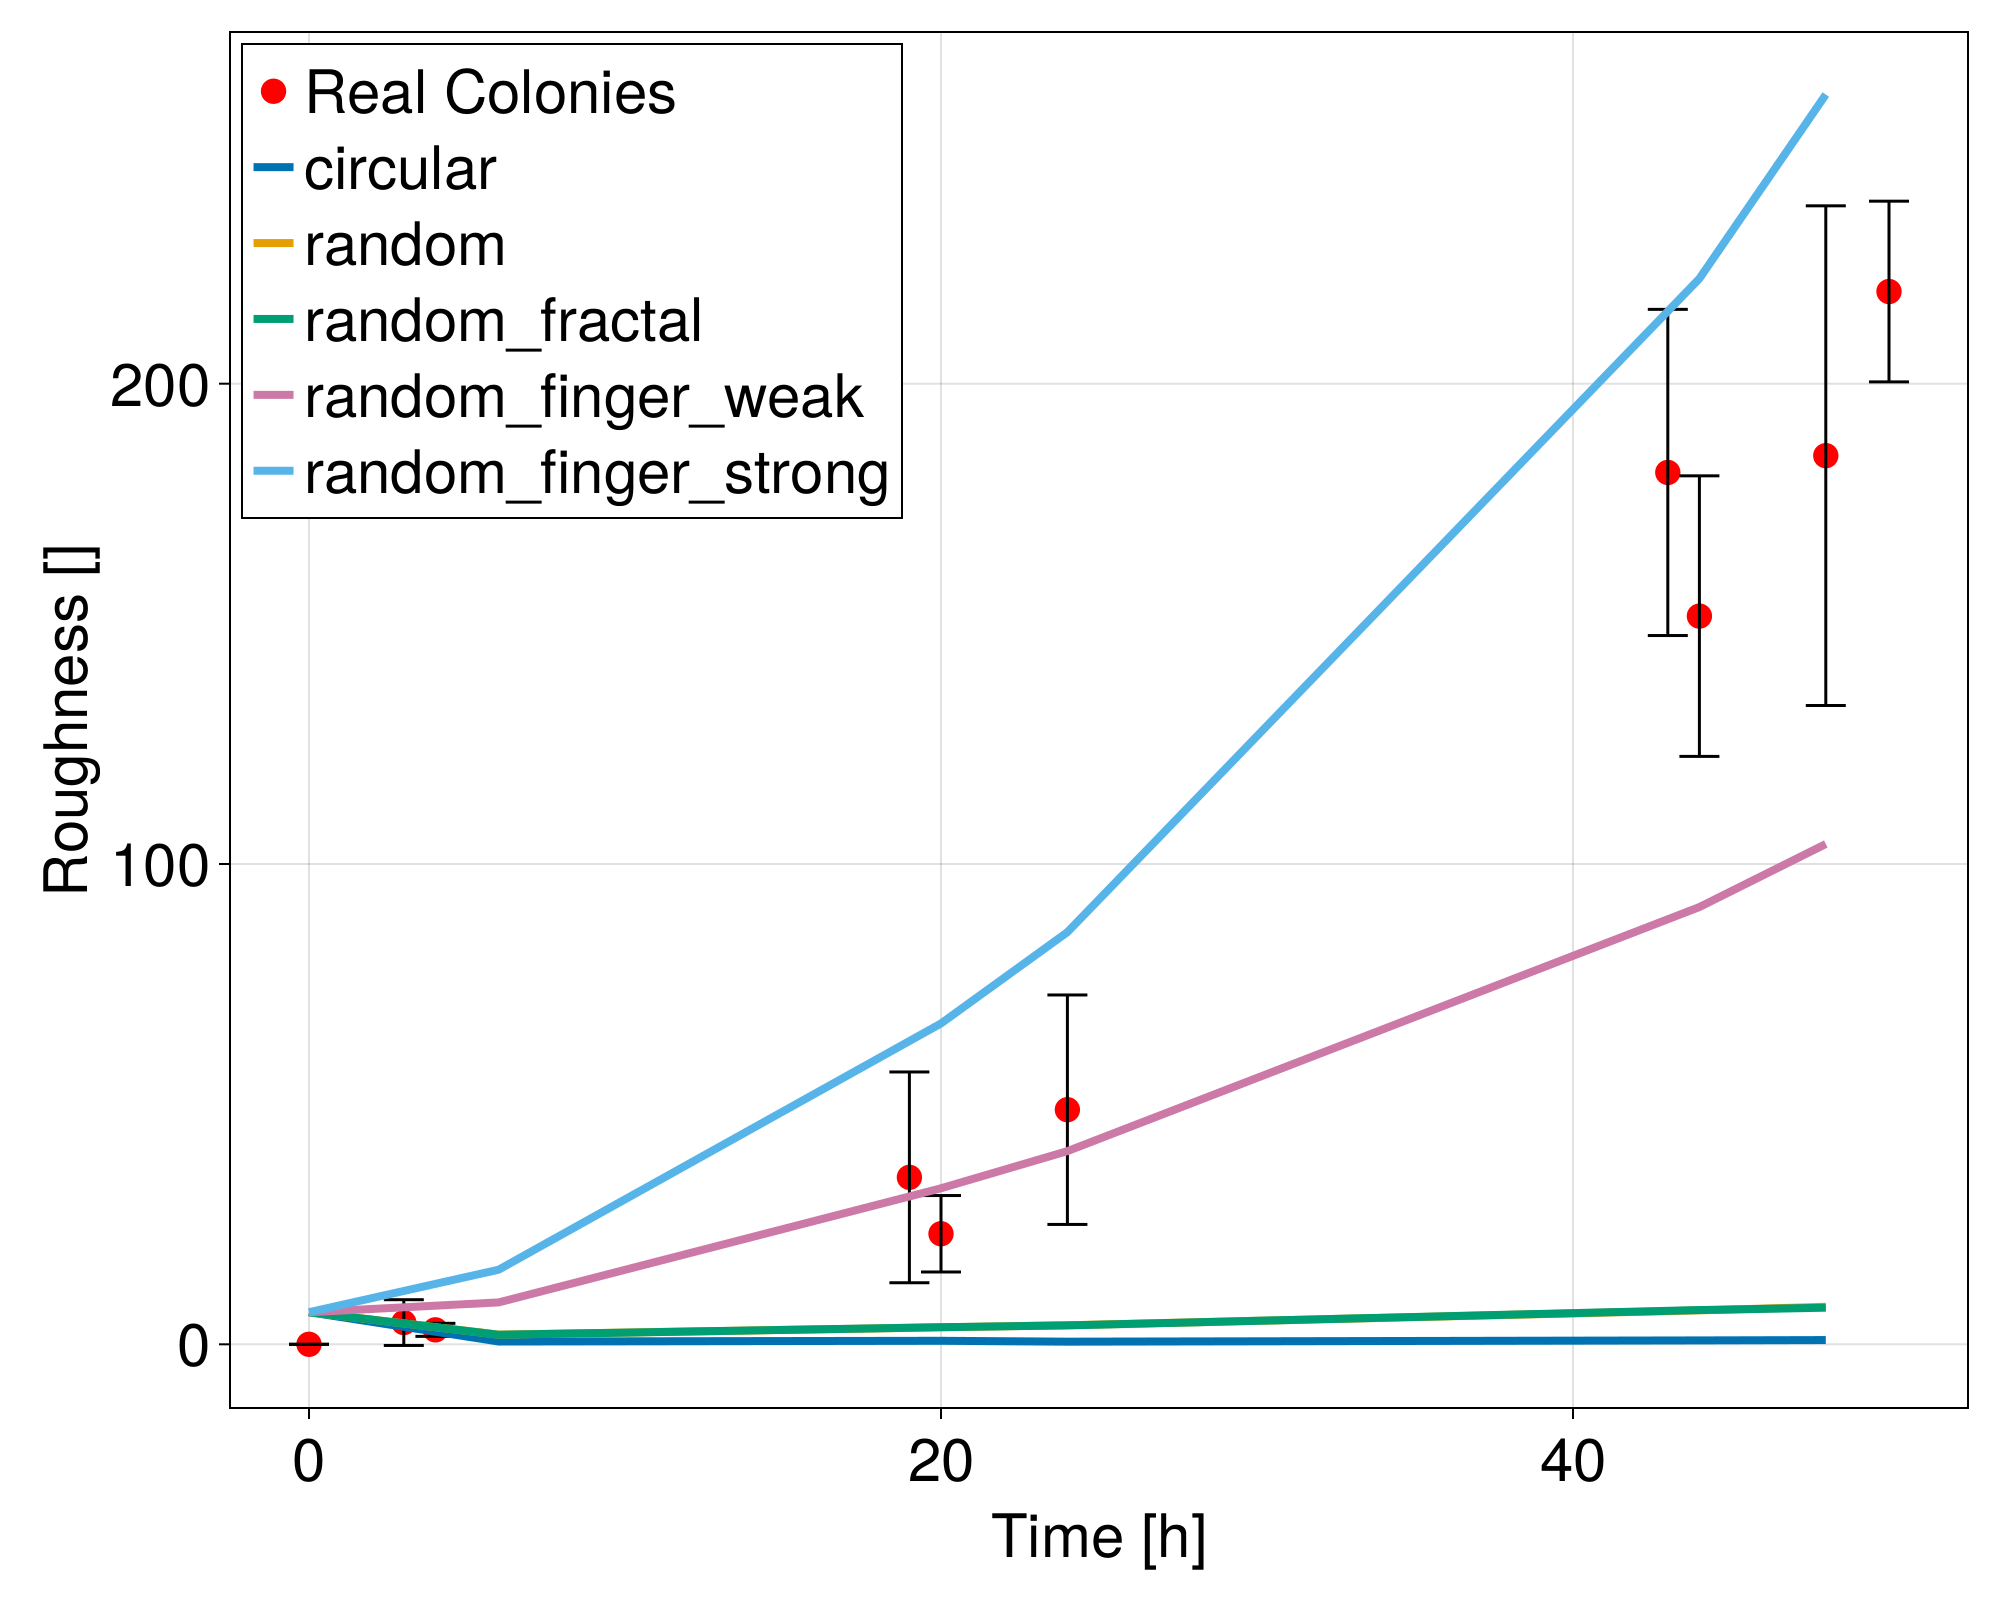

In [187]:
fig30 = Figure()
ax = CairoMakie.Axis(fig30[1,1])
scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, color = "red")
errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_RMS.pdf"),fig3)
fig30

## Fourier Transform on data set 

In [188]:
fft_data = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)



fft_data_r = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data_r)
     


Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [189]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end
first(abs_fftw,3)

abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end
last(abs_fftw_single,3)

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,String,Float64,Float64,Float64,Float64
1,24,random_finger_strong 2023_09_14,1.62232e5,1.60361e5,7.87953,7.78866
2,44,random_finger_strong 2023_09_14,4.15695e5,4.13808e5,20.1901,20.0985
3,48,random_finger_strong 2023_09_14,4.86504e5,4.84621e5,23.6293,23.5379


In [190]:
abs_fftw_r = @chain fft_data_r begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r,3)

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_n_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,44,2.61143e5,2.59082e5,17.0809,16.9521,3.08389
2,48,3.32596e5,3.30848e5,16.1378,16.0472,4.90487
3,50,3.6632e5,3.64281e5,21.7879,21.6687,2.94679


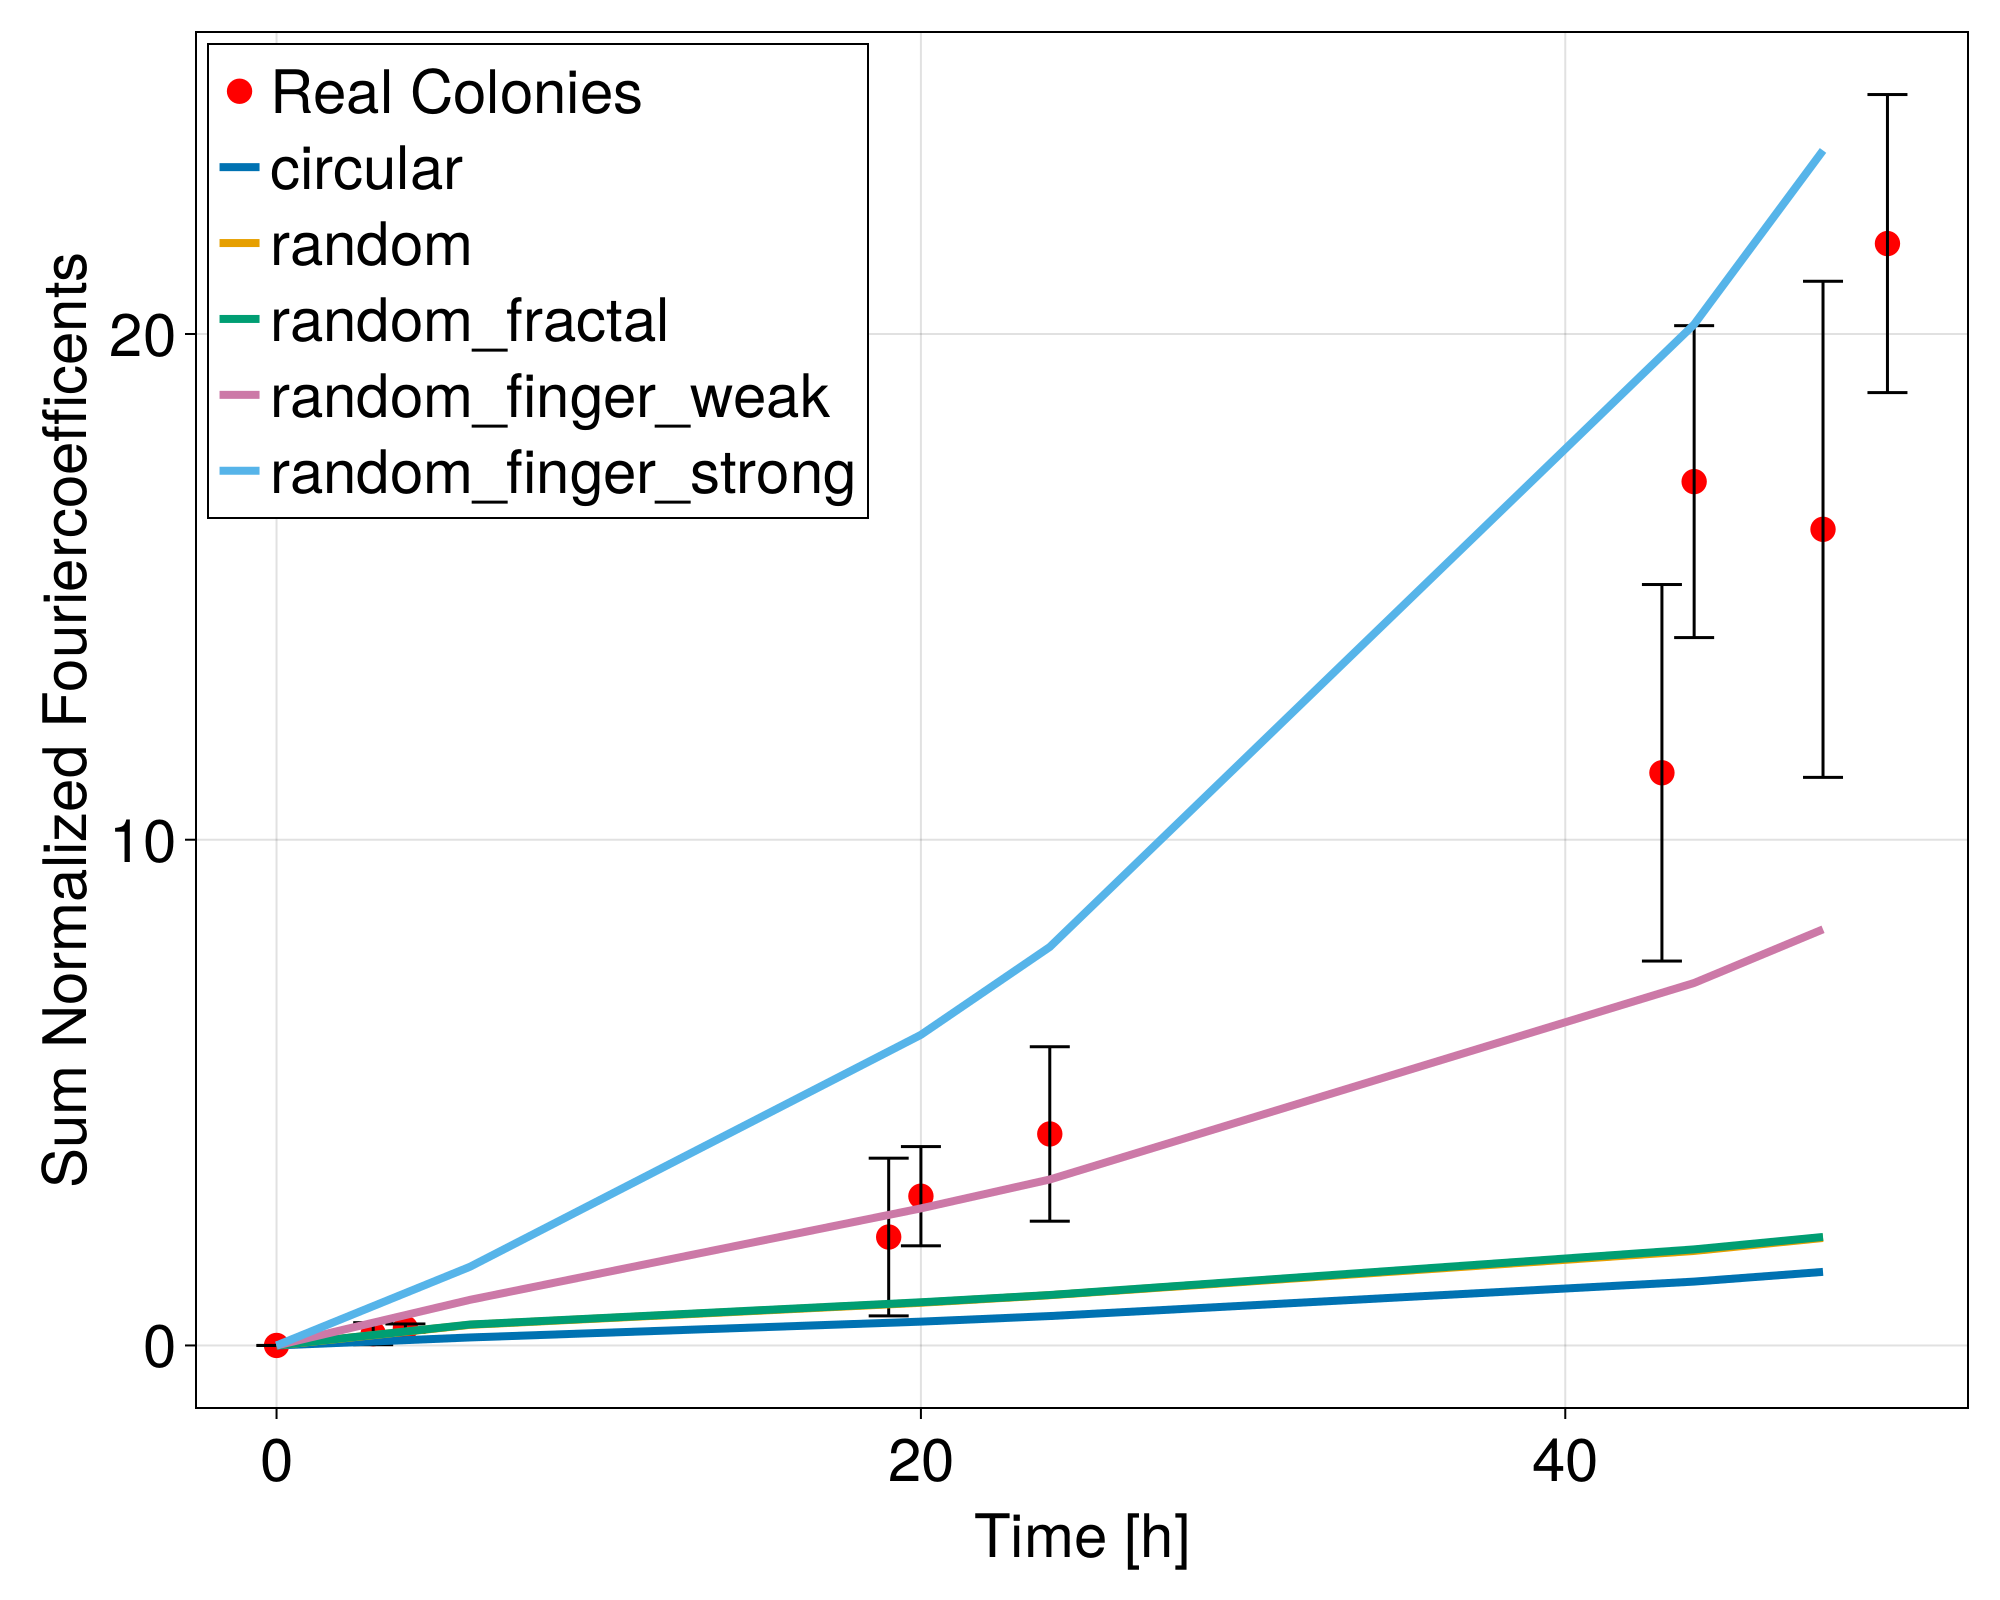

In [191]:
fig5 = Figure()
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff.pdf"),fig5)
fig5

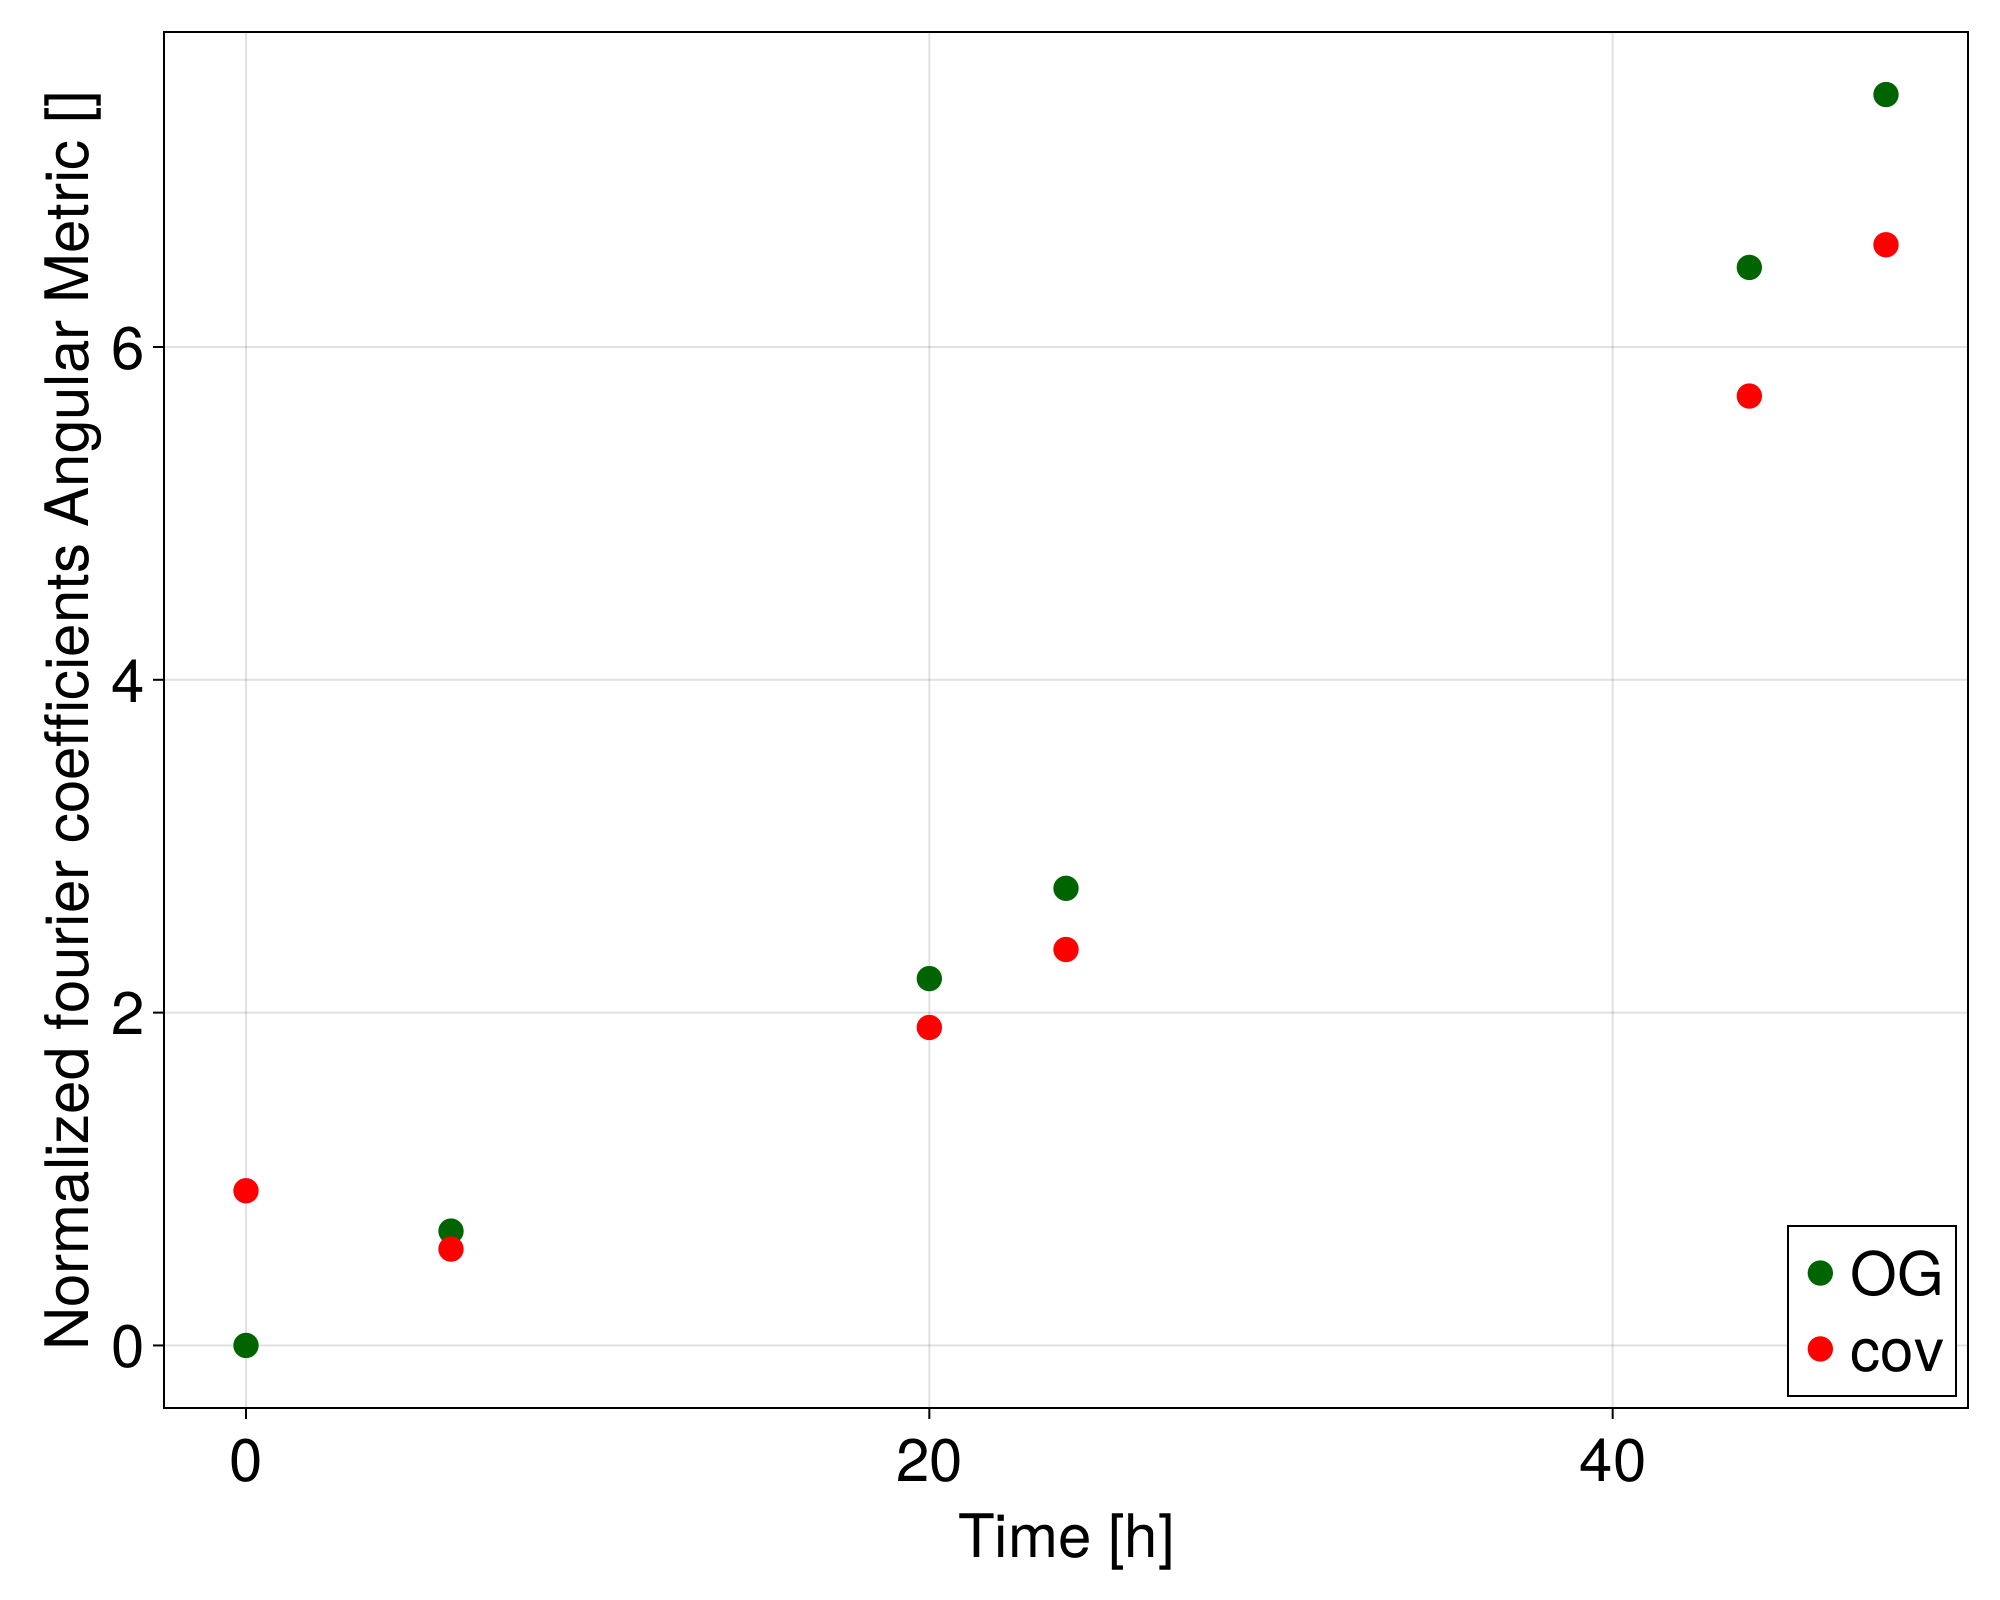

In [192]:
fig4 = scatter(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "OG")
scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10, label =  "cov")
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :rb)
save(joinpath(path,"Average Normalized fourier coefficients Angular Metric Angular Metric.png"),fig4)
fig4


In [172]:
test_spec = fft_data.abs_OG_n[800];

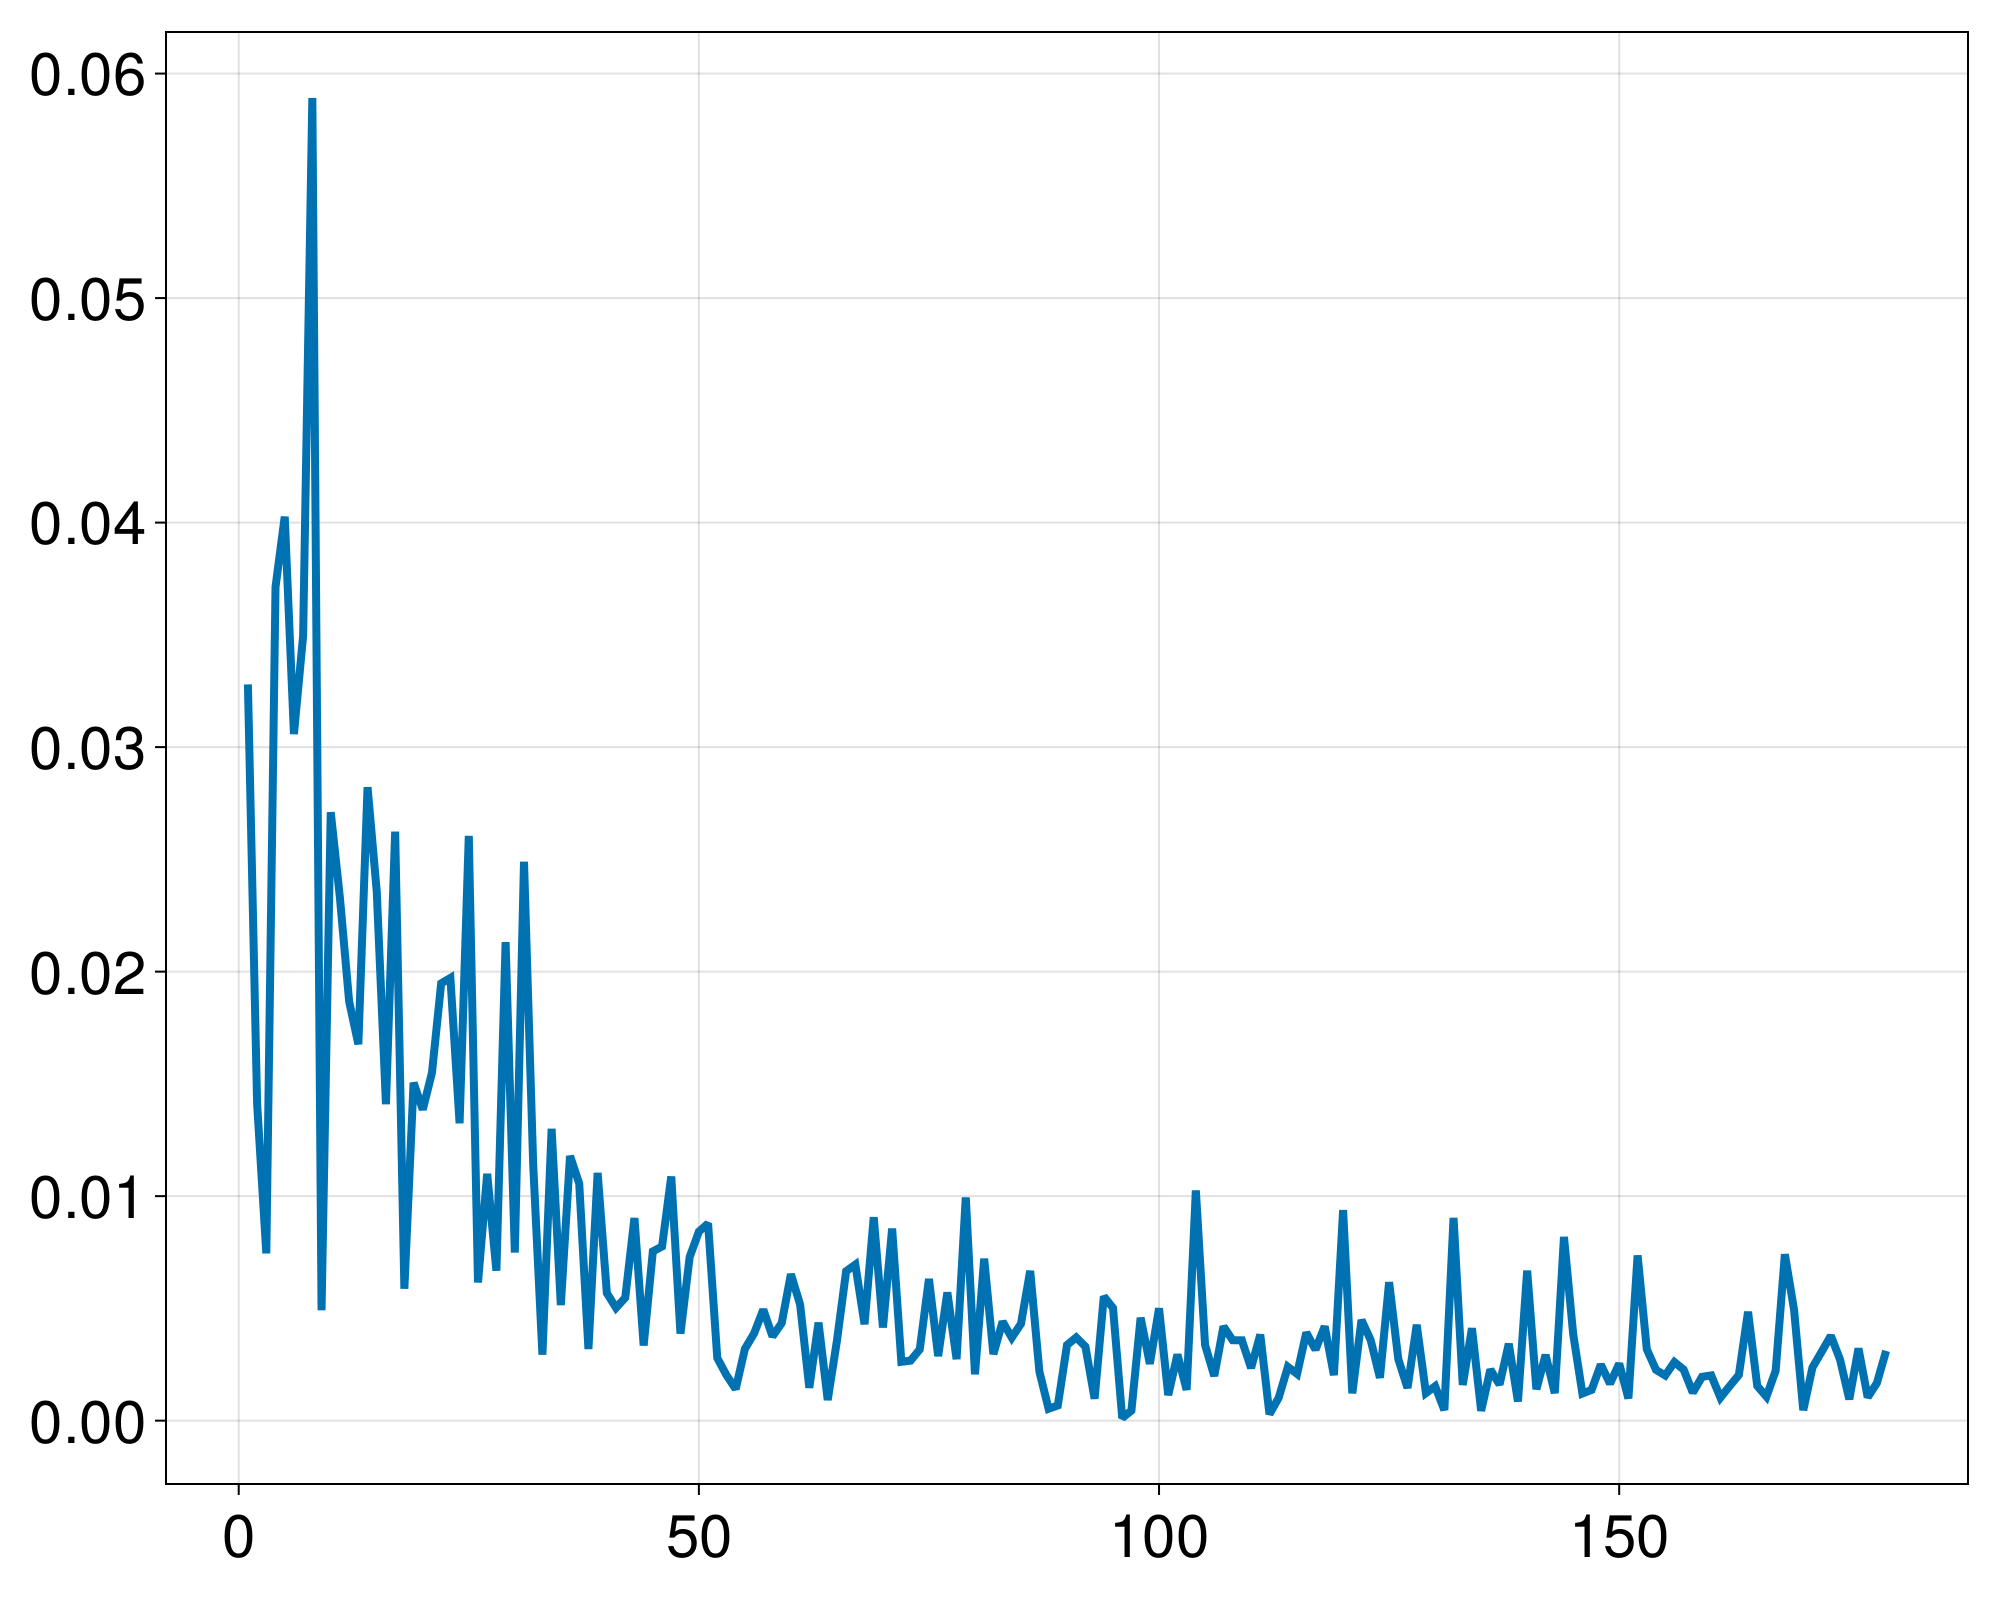

In [173]:
lines(test_spec)

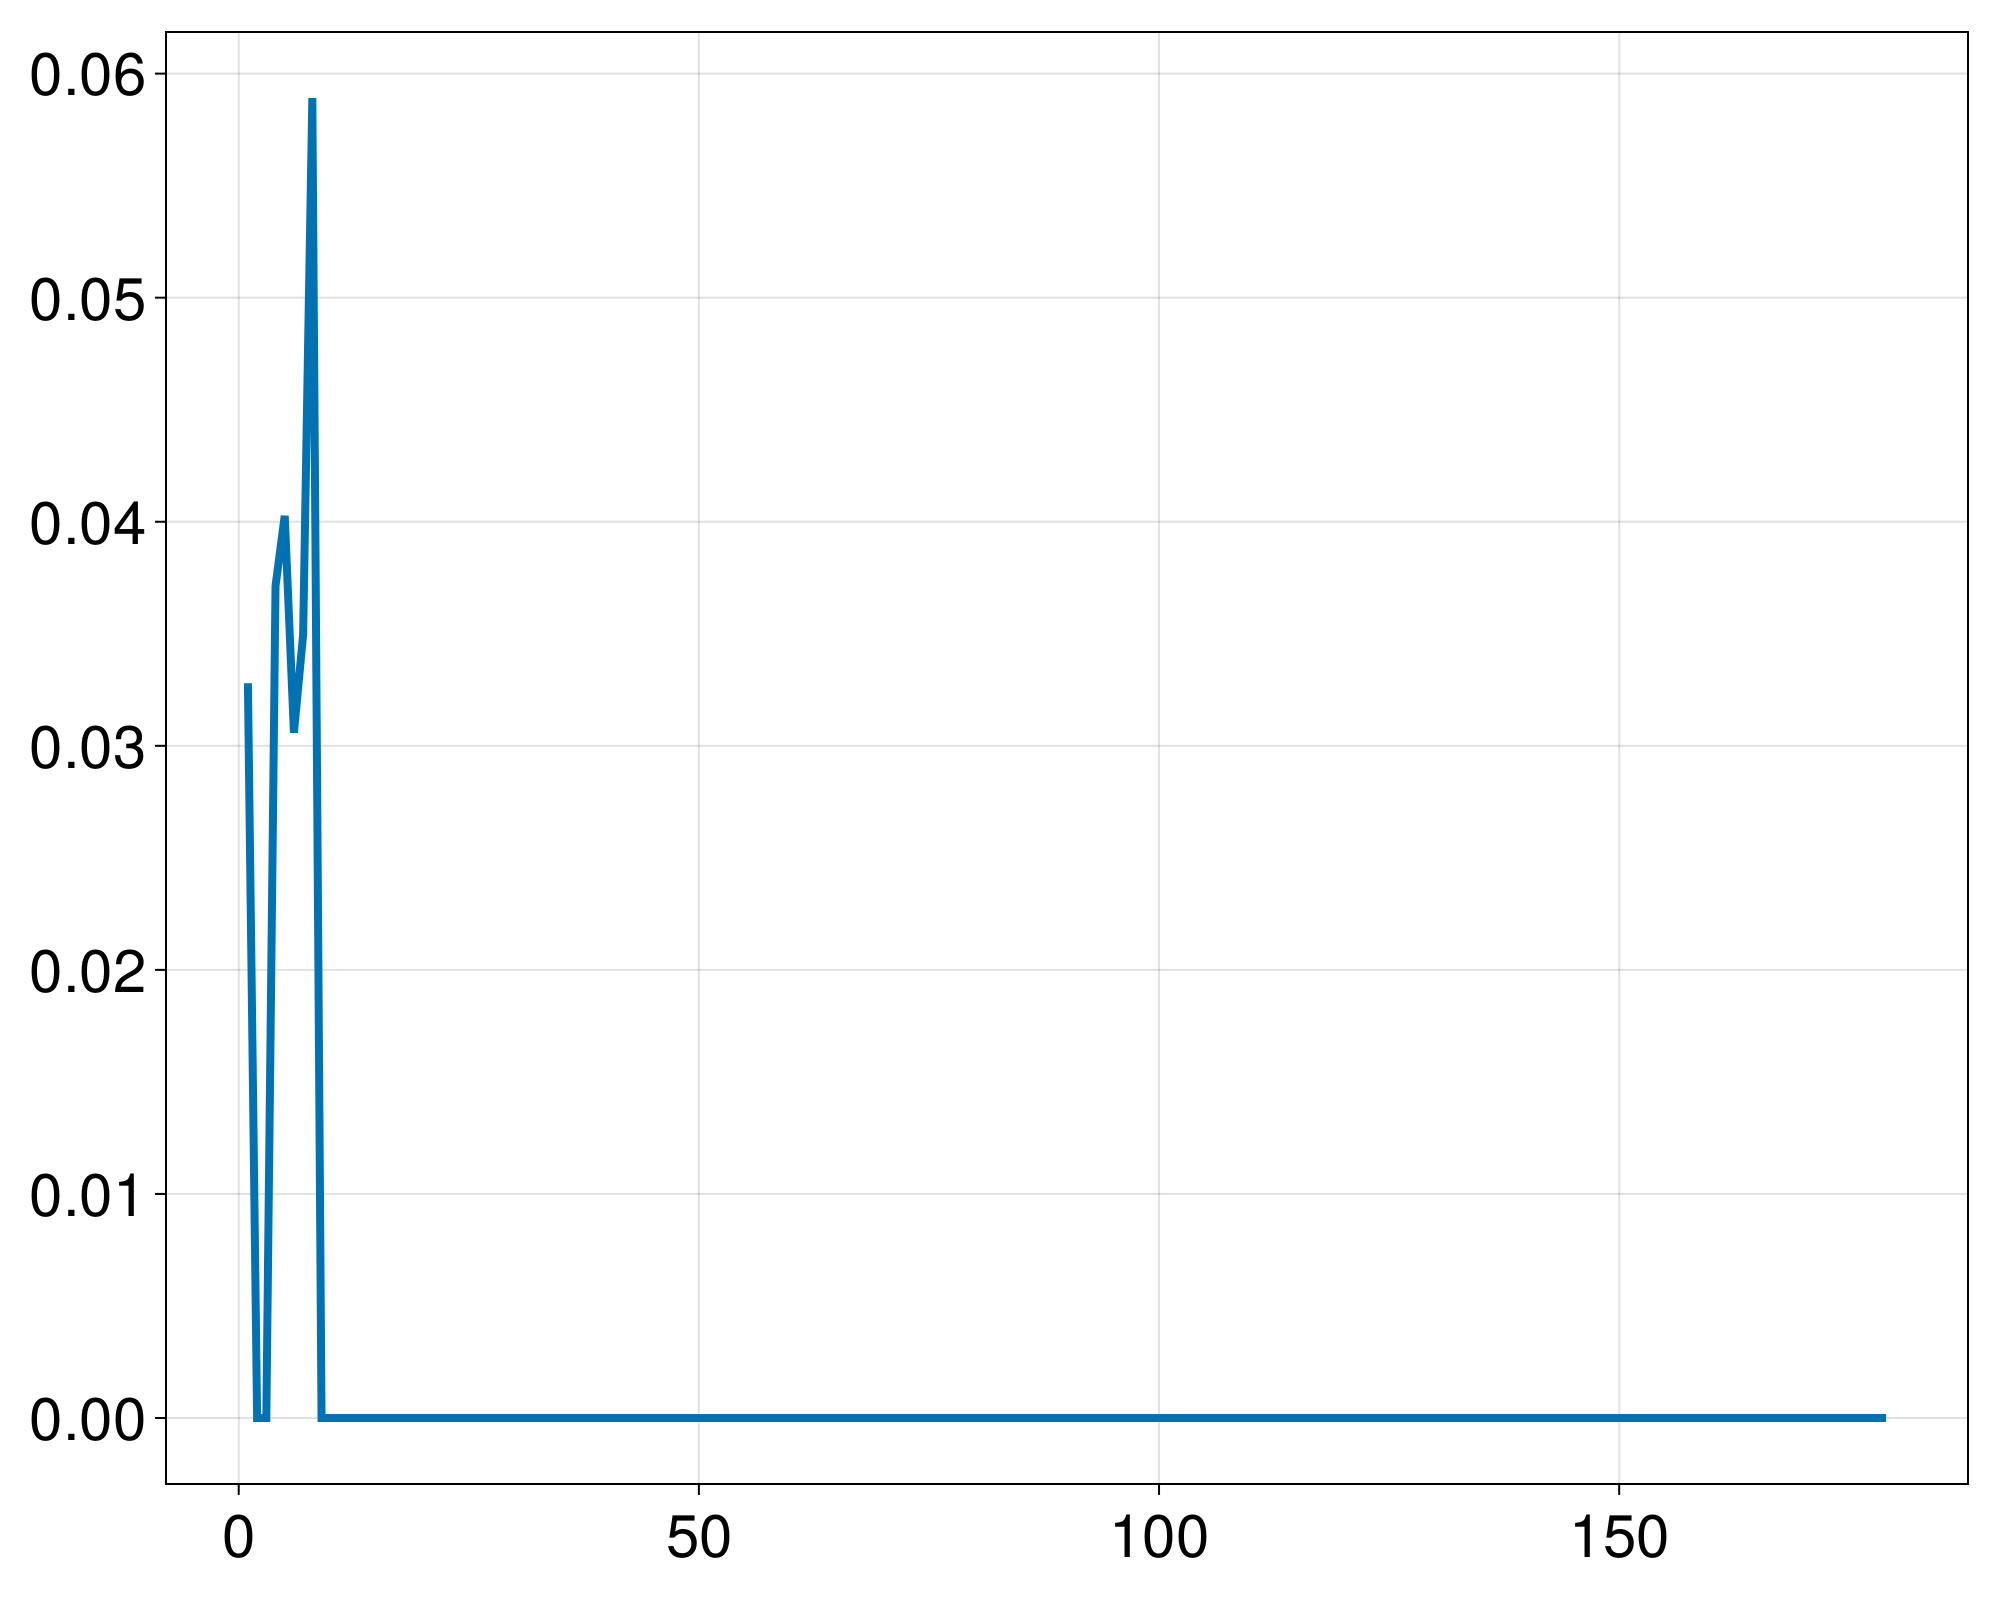

In [174]:
test_spec_fil_b = filter_fourier_beta(test_spec);
lines(test_spec_fil_b)

In [42]:
all_frequ = vcat(filter_fourier_beta2.(fft_data.abs_OG_n)...)

171840-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [43]:
histo_data = vcat(find_freq.(filter_fourier_beta2.(fft_data.abs_OG_n[600:end], b  =0.5))...);

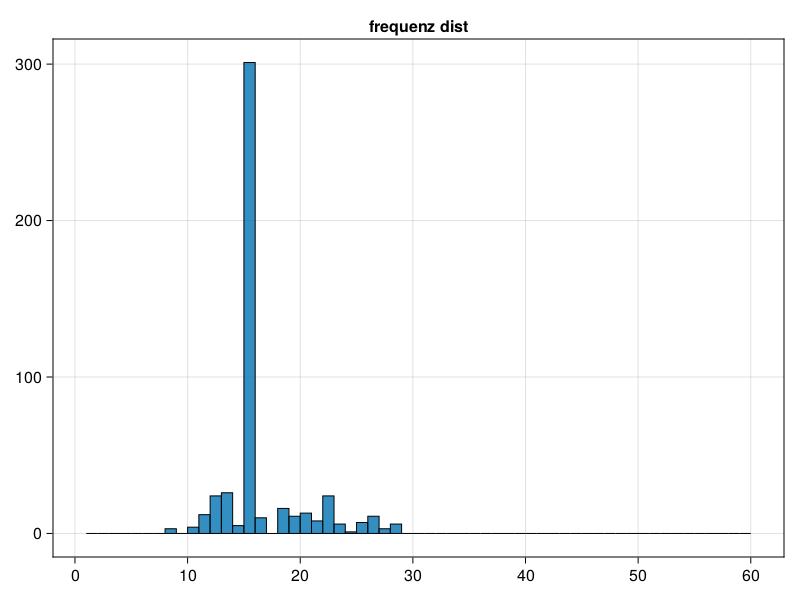

In [44]:
hans = hist(histo_data, bins = 1:60,strokewidth = 1)
hans.axis.title =  "frequenz dist"
hans

### Size increase measure in pixel in circular metric

In [45]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [46]:
size_data = @chain data begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_cov)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
end

Row,time,abs_size,abs_size_normalized,OG_size
,Int64,Float64,Float64,Float64
1,0,20589.0,0.0,20589.0
2,6,1858.99,0.193479,20589.0
3,20,6337.47,0.799395,20589.0
4,24,8035.41,1.02457,20589.0
5,44,19564.9,2.6351,20589.0
6,48,22634.1,3.08894,20589.0


In [47]:
cor_size = size_data.abs_size_normalized.+1

6-element Vector{Float64}:
 1.0
 1.1934792243430958
 1.7993950046141145
 2.0245725873038998
 3.635102481907815
 4.088942517849337

In [48]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_data.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.029773932609948355], [0.0, -0.000998509640892875, -0.001195471417507754, -0.0024594221588283283, 0.0010604677267647133, -8.651963199213242e-7], [0.0; 6.9480145714533945; … ; 155.3653344520713; 190.5944553056881;;], true, Float64[])

In [49]:
y2 = ex(size_data.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.029773932609948355

In [50]:
1/fit2.param[1]

33.58642652619796

In [51]:
fit2.resid

6-element Vector{Float64}:
  0.0
 -0.000998509640892875
 -0.001195471417507754
 -0.0024594221588283283
  0.0010604677267647133
 -8.651963199213242e-7

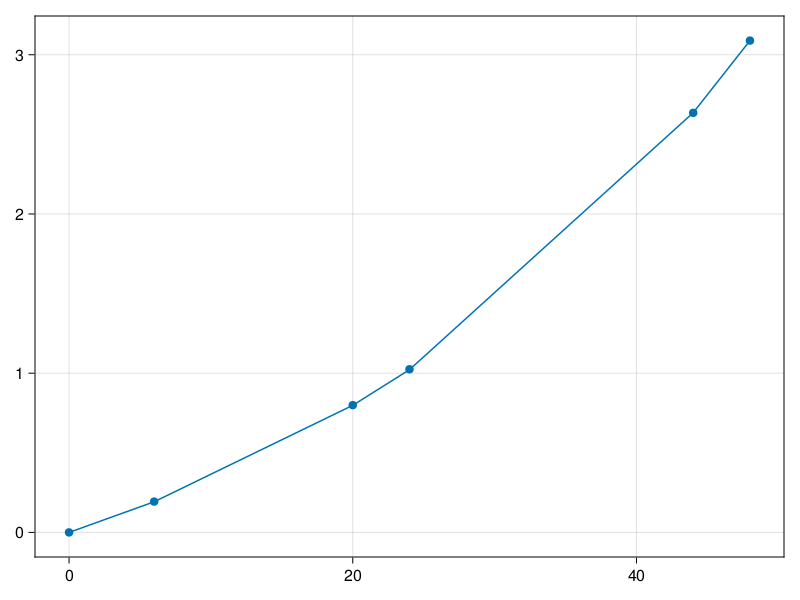

In [52]:
fig10 =scatter(size_data.time, size_data.abs_size_normalized)
lines!(fig10.axis, size_data.time, y2.-1)
fig10

In [53]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [54]:
size(data)

(960, 8)

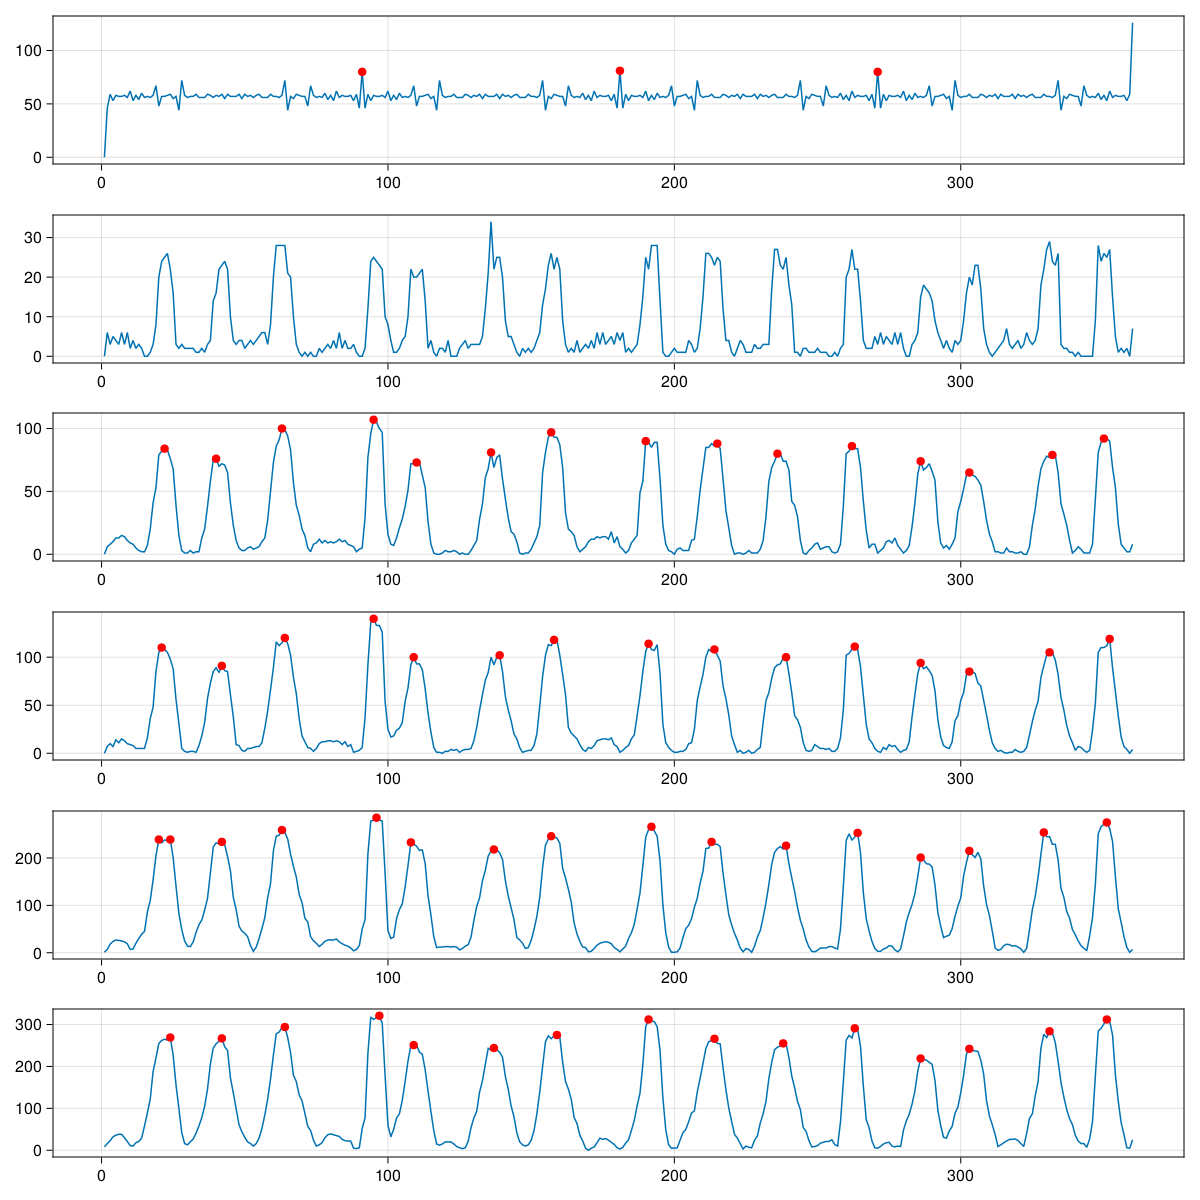

In [55]:
fig6 = Figure(resolution =(1200,1200))
for i in 1:6
    data1 = data.metric_cov[i+642];
    ax = CairoMakie.Axis(fig6[i,1])
    lines!(ax, data1)
    pkindices, properties = findpeaks1d(data1, prominence=0.6*mean(data1), distance = 4, height = 50)
    scatter!(ax, pkindices, data1[[pkindices...]],color = "red" )
end
fig6

In [56]:
peaks_full  = @chain data begin 
    @transform(:nr_peaks_cov = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 40)[1] for i in :metric_cov])  )
end
first(peaks_full)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,nr_peaks_cov
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589,12


In [57]:
peaks_over_time = @chain peaks_full begin
    groupby(:time)
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end


Row,time,peaks_mean,peaks_stdd
,Int64,Float64,Float64
1,0,12.0,0.0
2,6,1.68125,3.3988
3,20,5.98125,7.35401
4,24,6.025,7.40894
5,44,6.1625,7.20926
6,48,6.325,7.0582


In [58]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end

Row,time,data_set,peaks_mean,peaks_stdd
,Int64,String,Float64,Float64
1,0,circular 2023_09_14,12.0,0.0
2,6,circular 2023_09_14,0.0,0.0
3,20,circular 2023_09_14,0.0,0.0
4,24,circular 2023_09_14,0.0,0.0
5,44,circular 2023_09_14,0.0,0.0
6,48,circular 2023_09_14,0.0,0.0
7,0,random 2023_09_14,12.0,0.0
8,6,random 2023_09_14,0.0,0.0
9,20,random 2023_09_14,0.0,0.0


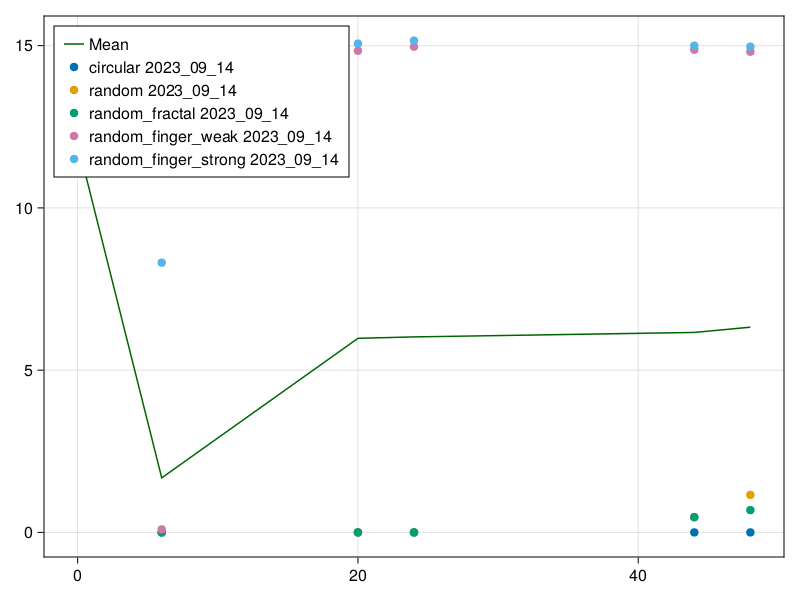

In [59]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatter!(fig7.axis, i.time, i.peaks_mean, label = String(k.data_set))
end
axislegend(fig7.axis, position = :lt)
fig7


In [60]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

LoadError: UndefVarError: `df_f` not defined

In [61]:
pair_10 = @chain data begin
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    

end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64


In [62]:
fig = CairoMakie.scatter(pair_10.pair_og)
errorbars!(1:length(pair_10.time),pair_10.pair_og, pair_10.pair_og_stdd,whiskerwidth = 10)
fig

LoadError: `Makie.convert_arguments` for the plot type LineSegments{Tuple{Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [49]:
data_14 = @subset(data,:data_set .== "14_06_23_stacked_full_res")
first(data_14,3)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
